# Gumbel integral 
In this notebook we present an efficient way of evaluating the gumbel integral using results from Fog https://www.tandfonline.com/doi/abs/10.1080/03610910701790236


In [142]:
import numpy as np
import random
import matplotlib.pyplot as plt

from scipy.integrate import quad
from scipy.optimize import fsolve
from math import sqrt, pi


In [68]:
# Toy example
seed = 0
N = 100       # population size
n = 10        # sample size
random.seed(seed)

w = np.arange(1,N+1)    # weights 
w = w/sum(w)
#s = random.sample(list(np.arange(N)),n)   # sample indexed  
s = np.arange(N)[-n:]
sc = list(set(np.arange(N))-set(s))       # remaining indexes
d = sum(w[sc])    # weight sum of S complement

print('Population size is {}, sample size is {}, sample weight sum is {:.4f}.'.format(N,n,1-d))

Population size is 100, sample size is 10, sample weight sum is 0.1891.


In [78]:
from math import cos, exp, pi


# function we want to integrate
def f(x):
    return x**2 + 2*x+1

def nf(x,p):
    integrand = 1
    for i in range(p):
        integrand *= x+1
    return integrand

# call quad to integrate f from -2 to 2
res, err = quad(f, -2, 2)
nres, nerr = quad(nf, -2, 2, args=(3))

print("The numerical result is {:f} (+-{:g})"
    .format(res, err))
print("Nested numerical result is {:f} (+-{:g})"
    .format(nres, nerr))

The numerical result is 9.333333 (+-1.03621e-13)
Nested numerical result is 20.000000 (+-2.27595e-13)


In [146]:
def integrand(x,w,s,d):
    T = 1
    for i in s:
        T *= (1 - x ** (w[i] / d))
    return T

def trans_integrand(x,w,s,d,r):
    T = 1
    for i in s:
        T *= (1 - x ** (w[i] * r))
    return r*d * x**(r*d - 1) * T

def z(r,w,s,d):
    res = d - 1/r
    for i in s:
        res -= w[i] / (2**(r*w[i]) - 1)
    return res

# Laplace's method (Second order approximation)
def laplace_approx(t,w,s,d,r):
    res = (1-r*d)/t**2
    for i in s:
        rw = r * w[i]
        res -= ((1-t**(rw)) * rw * (rw - 1) * t**(rw-2) + (rw)**2 * t**(2*rw-2))/(1-t**(rw))**2
    return trans_integrand(t,w,s,d,r) * sqrt(-2*pi / (res))

# check if the transformed integrand is suitable for Laplace's method by 
# examining the shape of the integrand and the normalized d
def check_shape(w,s,d,r, bin=1000):
    x = np.linspace(0, 1, bin, endpoint=True)
    y = trans_integrand(x,w,s,d,r)
    plt.plot(x, y)
    plt.ylabel('transformed integrand')
    plt.show()
    E = 1/d
    print('The reciprocal of d is {}, note if the value is too large, Laplace method is generally not recommended.'.format(1/d))

In [127]:
res, err = quad(integrand, 0, 1, args=(w,s,d))
print("Direct integration"+"\n"+"-"*25+"\nResult: {} \nError: {} \nRelative error: {}".format(res, err, err/res))

Direct integration
-------------------------
Result: 1.6753994001578263e-11 
Error: 3.1512149218908557e-11 
Relative error: 1.8808738510912708


In [140]:
r = fsolve(z, 1/d, (w,s,d))[0]
tres, terr = quad(trans_integrand, 0, 1, args=(w,s,d,r))
print("Transformed integration"+"\n"+"-"*25+"\nResult: {} \nError: {} \nRelative error: {}".format(tres, terr, terr/res))

Transformed integration
-------------------------
Result: 5.234360238656979e-11 
Error: 2.1641618085938836e-15 
Relative error: 0.00012917288906693023


In [141]:
lres = laplace_approx(0.5,w,s,d,r)
print("Laplace's method"+"\n"+"-"*25+"\nResult: {}".format(lres))

Laplace's method
-------------------------
Result: 5.4250491277283665e-11


In [138]:
trans_integrand(0.5,w,s,d,r)

array([1.97064403e-10])

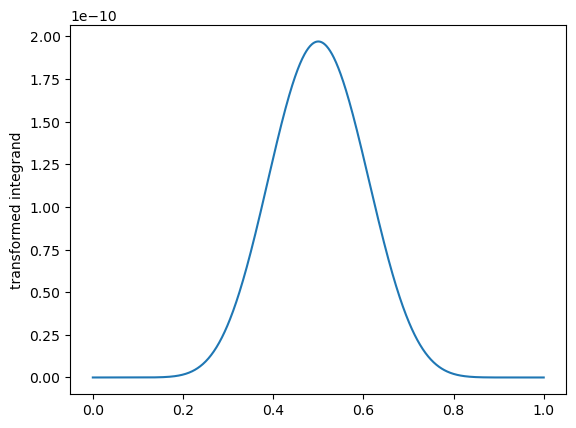

The reciprocal of d is 1.2332112332112324, note if the value is too large, Laplace method is generally not recommended.


In [147]:
check_shape(w,s,d,r)